In [9]:
!pip install git+git://github.com/geopandas/geopandas.git
!pip install earthpy
!pip install descartes # required for plotting polygons in geopandas

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-dgc2s7dt
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-dgc2s7dt
  Created wheel for geopandas: filename=geopandas-0.8.0+52.g7e595d0-py2.py3-none-any.whl size=969239 sha256=8a6ed82d31d1454d84afd27877a94dc8edf0a3cd1e069317b63bc5d72123f067
  Stored in directory: /tmp/pip-ephem-wheel-cache-9kxvalzy/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas


In [10]:
# import necessary packages
%matplotlib inline
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import pandas as pd
pd.options.display.float_format
from tqdm.notebook import tqdm

# Understanding the Shape File

In [11]:
# Load the shape file from github
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape.zip -d shape

This part will help us understand what the Los Angeles County shapefile contains

In [12]:
# Let's take a look at the shapefile
neighborhood_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
print(neighborhood_shapes.head()) # view the data attribute table 
print("Shape: ", neighborhood_shapes.shape)
print(neighborhood_shapes.columns)

              slug  ...                                           geometry
0            acton  ...  POLYGON ((-118.20262 34.53899, -118.18947 34.5...
1  adams-normandie  ...  POLYGON ((-118.30901 34.03741, -118.30041 34.0...
2     agoura-hills  ...  POLYGON ((-118.76193 34.16820, -118.72632 34.1...
3       agua-dulce  ...  POLYGON ((-118.25468 34.55830, -118.25551 34.5...
4         alhambra  ...  POLYGON ((-118.12175 34.10504, -118.11687 34.1...

[5 rows x 11 columns]
Shape:  (272, 11)
Index(['slug', 'set', 'kind', 'external_i', 'name', 'display_na', 'sqmi',
       'type', 'name_1', 'slug_1', 'geometry'],
      dtype='object')


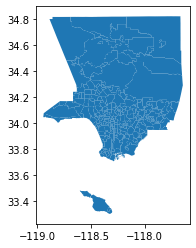

In [ ]:
neighborhood_shapes.plot()

# Understanding the Lodes Data


In [13]:
!wget --directory-prefix=data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/lodes_la_rac_S000_JT00_2017.csv
lodes_filename = 'data/lodes_la_rac_S000_JT00_2017.csv'

lodes_data = pd.read_csv(lodes_filename, skiprows=[1])
# Convert h_geocode column to string for future use
# lodes_data['h_geocode'] = lodes_data['h_geocode'].apply(str)

In [ ]:
lodes_data.head()

,h_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate
0,60371011101001,29,6,15,8,6,9,14,0,0,0,1,0,2,3,0,4,0,2,1,0,1,0,7,3,2,1,2,24,0,0,5,0,0,27,2,2,7,4,10,11,18,20190825
1,60371011101002,40,5,20,15,10,12,18,0,0,0,2,3,3,4,2,3,1,1,1,0,3,5,7,2,2,0,1,33,2,1,4,0,0,34,6,2,5,17,11,20,20,20190825
2,60371011101003,44,10,18,16,12,11,21,1,0,0,2,1,5,5,0,3,0,3,4,0,1,0,11,1,3,3,1,44,0,0,0,0,0,34,10,6,9,7,12,23,21,20190825
3,60371011101004,72,12,35,25,22,25,25,0,0,0,1,4,2,7,4,8,1,3,2,0,6,8,15,2,4,0,5,64,2,1,4,0,1,60,12,7,9,20,24,31,41,20190825
4,60371011101005,66,17,38,11,19,28,19,0,0,1,3,4,3,7,2,5,2,0,1,0,5,5,21,1,3,1,2,63,0,0,3,0,0,50,16,4,13,13,19,31,35,20190825


In [ ]:
lodes_data.describe()

,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate
count,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.00000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.000000,386143.0
mean,43.291136,9.696082,23.933778,9.661276,9.258355,13.745009,20.287772,0.990053,0.048122,0.280417,2.125839,3.359908,1.866179,4.210318,1.522343,1.609709,1.417027,0.743359,3.242325,0.646828,2.786517,3.808706,6.229539,0.936241,4.28283,1.419277,1.765597,31.295155,2.907943,0.556234,7.063966,0.205890,1.261947,28.537829,14.753306,6.143657,6.909344,10.070697,10.471356,22.167692,21.123444,20190825.0
std,65.523440,15.627164,36.997494,14.451909,14.441512,21.841121,33.206494,3.078153,0.290148,0.683815,3.593323,6.116942,3.385366,6.739584,2.891177,4.644835,2.782776,1.500134,6.856919,1.383964,4.847495,6.031677,9.998289,1.830573,7.09423,2.513186,3.260271,46.180097,8.131766,1.499507,18.613020,0.824237,2.517044,46.766780,28.143656,10.354415,10.450937,15.245426,17.957130,33.973166,32.003163,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20190825.0
25%,9.000000,2.000000,5.000000,2.000000,2.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,2.000000,2.000000,5.000000,4.000000,20190825.0
50%,24.000000,5.000000,13.000000,5.000000,5.000000,7.000000,11.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,3.000000,0.000000,2.00000,1.000000,1.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,6.000000,3.000000,4.000000,6.000000,5.000000,12.000000,12.000000,20190825.0
75%,51.000000,11.000000,28.000000,12.000000,11.000000,16.000000,24.000000,1.000000,0.000000,0.000000,3.000000,4.000000,2.000000,5.000000,2.000000,2.000000,2.000000,1.000000,4.000000,1.000000,3.000000,5.000000,7.000000,1.000000,5.00000,2.000000,2.000000,37.000000,3.000000,0.000000,7.000000,0.000000,2.000000,33.000000,17.000000,7.000000,8.000000,12.000000,12.000000,26.000000,25.000000,20190825.0
max,1742.000000,572.000000,1045.000000,402.000000,390.000000,886.000000,1469.000000,363.000000,24.000000,21.000000,102.000000,336.000000,103.000000,242.000000,136.000000,228.000000,91.000000,47.000000,431.000000,56.000000,144.000000,307.000000,270.000000,65.000000,246.00000,92.000000,206.000000,1530.000000,423.000000,55.000000,1038.000000,39.000000,73.000000,1589.000000,1295.000000,511.000000,283.000000,443.000000,653.000000,1147.000000,792.000000,20190825.0


In [ ]:
# Todo: Add more graphs visualizing this. We'll save graphs of key features for later imo

## Getting centroid latitude and longitude of each tract from lodes walk file

In [14]:
!wget --directory-prefix=data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/lodes_la_xwalk.csv
lodes_info_filename = 'data/lodes_la_xwalk.csv'

lodes_centroid_info = pd.read_csv(lodes_info_filename)

# Format GEOID in the same way as SocialExplorer
# census_tract_centroid_info["GEOID"] = census_tract_centroid_info["GEOID"].str[10:].str.strip()

lodes_centroid_info.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tabblk2010,st,stusps,stname,cty,ctyname,trct,trctname,bgrp,bgrpname,cbsa,cbsaname,zcta,zctaname,stplc,stplcname,ctycsub,ctycsubname,stcd116,stcd116name,stsldl,stsldlname,stsldu,stslduname,stschool,stschoolname,stsecon,stseconname,trib,tribname,tsub,tsubname,stanrc,stanrcname,necta,nectaname,mil,milname,stwib,stwibname,blklatdd,blklondd,createdate
0,60376011001000,6,CA,California,6037,"Los Angeles County, CA",6037601100,"6011 (Los Angeles, CA)",60376011001,"1 (Tract 6011, Los Angeles, CA)",31080,"Los Angeles-Long Beach-Anaheim, CA",90301,90301.0,636546,"Inglewood city, CA",603791400,"Inglewood CCD (Los Angeles, CA)",643,CA-43,6062,"Assembly District 62, CA",6035,"State Senate District 35, CA",618390,"Inglewood Unified School District, CA",9999999,NaN,99999,NaN,9999999,NaN,9999999,NaN,99999,NaN,NaN,NaN,6000061,61 South Bay Consortium WIB,33.948782,-118.345293,20190826
1,60376010023006,6,CA,California,6037,"Los Angeles County, CA",6037601002,"6010.02 (Los Angeles, CA)",60376010023,"3 (Tract 6010.02, Los Angeles, CA)",31080,"Los Angeles-Long Beach-Anaheim, CA",90301,90301.0,636546,"Inglewood city, CA",603791400,"Inglewood CCD (Los Angeles, CA)",643,CA-43,6062,"Assembly District 62, CA",6035,"State Senate District 35, CA",618390,"Inglewood Unified School District, CA",9999999,NaN,99999,NaN,9999999,NaN,9999999,NaN,99999,NaN,NaN,NaN,6000061,61 South Bay Consortium WIB,33.959576,-118.347870,20190826
2,60376023023008,6,CA,California,6037,"Los Angeles County, CA",6037602302,"6023.02 (Los Angeles, CA)",60376023023,"3 (Tract 6023.02, Los Angeles, CA)",31080,"Los Angeles-Long Beach-Anaheim, CA",90250,90250.0,632548,"Hawthorne city, CA",603791400,"Inglewood CCD (Los Angeles, CA)",643,CA-43,6062,"Assembly District 62, CA",6035,"State Senate District 35, CA",601428,"Wiseburn Unified School District, CA",9999999,NaN,99999,NaN,9999999,NaN,9999999,NaN,99999,NaN,NaN,NaN,6000061,61 South Bay Consortium WIB,33.914658,-118.371617,20190826
3,60376014013008,6,CA,California,6037,"Los Angeles County, CA",6037601401,"6014.01 (Los Angeles, CA)",60376014013,"3 (Tract 6014.01, Los Angeles, CA)",31080,"Los Angeles-Long Beach-Anaheim, CA",90301,90301.0,636546,"Inglewood city, CA",603791400,"Inglewood CCD (Los Angeles, CA)",643,CA-43,6062,"Assembly District 62, CA",6035,"State Senate District 35, CA",618390,"Inglewood Unified School District, CA",9999999,NaN,99999,NaN,9999999,NaN,9999999,NaN,99999,NaN,NaN,NaN,6000061,61 South Bay Consortium WIB,33.962873,-118.372066,20190826
4,60376014013033,6,CA,California,6037,"Los Angeles County, CA",6037601401,"6014.01 (Los Angeles, CA)",60376014013,"3 (Tract 6014.01, Los Angeles, CA)",31080,"Los Angeles-Long Beach-Anaheim, CA",90301,90301.0,636546,"Inglewood city, CA",603791400,"Inglewood CCD (Los Angeles, CA)",643,CA-43,6062,"Assembly District 62, CA",6035,"State Senate District 35, CA",618390,"Inglewood Unified School District, CA",9999999,NaN,99999,NaN,9999999,NaN,9999999,NaN,99999,NaN,NaN,NaN,6000061,61 South Bay Consortium WIB,33.958094,-118.374416,20190826


In [15]:
for idx, lodes_tract in tqdm(lodes_centroid_info.iterrows(), total=lodes_centroid_info.shape[0]):
  # pd.to_numeric(lodes_data['h_geocode'])
  # print(lodes_data['h_geocode'].values, type(lodes_tract['tabblk2010']))
  
  # if lodes_data['h_geocode'].values[0] == lodes_tract['tabblk2010']:
  #   print("true")
  found_index = lodes_data.index[lodes_data['h_geocode'] == lodes_tract['tabblk2010']]
  # print(found_index[0])
  # print(found_index).astype('int32').dtypes
  # print(type(lodes_data['Latitude']), type(lodes_tract['blklatdd']))
  lodes_data.at[found_index, 'Latitude'] = lodes_tract['blklatdd']
  lodes_data.at[found_index, 'Longitude'] = lodes_tract['blklondd']
  lodes_data.at[found_index, 'Possible Neighborhood'] = lodes_tract['ctycsubname']

In [ ]:
lodes_data.head()

In [ ]:
# These two census tracts seem to no longer exist? Unsure, but will manually add their latitude and longitude
# broken1 = census_data.index[census_data['Name of Area'] == 'Census Tract 9901']
# census_data.at[broken1, 'Latitude'] = 33.99919090
# census_data.at[broken1, 'Longitude'] = -118.79218760
# census_data.at[broken1, 'Possible Neighborhood'] = 'Unknown'
# broken2 = census_data.index[census_data['Name of Area'] == 'Census Tract 9902']
# census_data.at[broken2, 'Latitude'] = 33.91358680
# census_data.at[broken2, 'Longitude'] = -118.49286930
# census_data.at[broken2, 'Possible Neighborhood'] = 'Unknown'

# Verify no more invalid rows
# import math
# for idx, row in census_data.iterrows():
#   if (math.isnan(row['Latitude'])):
#     print(row['Name of Area'], row['Latitude'], row['Longitude'])

The "Possible Neighborhood" column is from this new datasource (https://usc.data.socrata.com/widgets/atat-mmad). We will use the shapefile and polygon intersection to determine which census tract falls into which neighborhood and use this "Possible Neighborhood" to validate.

There are 262 "possible neighborhoods" versus 272 unique names from the shapefile.

The 10 missing are:

1.   Desert View Highlands
2.   Green Valley
3.   Hasley Canyon
4.   Lake Hughes
5.   Littlerock
6.   North El Monte
7.   South Diamond Bar
8.   Sun Village
9.   Val Verde
10.   West San Dimas

As a result, validation may not be perfect. Regardless, we want to use the shapefile to maintain consistency with the boundaries used by the USC Covid Risk Model.

# Polygon Intersection

In [16]:
from shapely.geometry import Point, Polygon
neighborhood_shapes = neighborhood_shapes[['name','geometry']]

neighborhood_census_data = pd.DataFrame(neighborhood_shapes['name'])
for feature in lodes_data.columns[1:]:
  neighborhood_census_data[feature] = 0
polys = neighborhood_shapes['geometry']

for idx, row in tqdm(lodes_data.iterrows(), total=lodes_data.shape[0]):
  mask = polys.contains(Point(row['Longitude'], row['Latitude']))
  # This Census Tract from the Lodes Data belongs to this particular neighborhood
  neighborhood_row = neighborhood_shapes[mask]
  if (len(neighborhood_row) == 0):
    print(row['h_geocode'])
  #   # These do not fall inside any polygon, but still have data. Since there are only a few, this will be done manually.
  #   if (row['Name of Area'] == 'Census Tract 1247'):
  #     neighborhood_row = neighborhood_shapes[neighborhood_shapes['name'] == 'Sherman Oaks']
  #   elif (row['Name of Area'] == 'Census Tract 9800.33'):
  #     neighborhood_row = neighborhood_shapes[neighborhood_shapes['name'] == 'San Pedro']
  #   else:
  #  continue
  else:
    neighborhood = neighborhood_row.iloc[0]
    for feature in row[1:-4].items():
      if (len(neighborhood_row) > 0):
        if ("%" in feature[0]): continue
        previous_value = neighborhood_census_data.loc[neighborhood_row.index, feature[0]].iloc[0]
        neighborhood_census_data.at[neighborhood_row.index, feature[0]] = previous_value + feature[1]

    

Streaming output truncated to the last 5000 lines.
60590891052006
60590891052007
60590891052010
60590891052011
60590891052012
60590891052013
60590891052014
60590891053001
60590891053002
60590891053003
60590891053008
60590891053009
60590891053010
60590891053011
60590891053012
60590891061001
60590891061002
60590891061003
60590891061004
60590891061005
60590891061007
60590891061008
60590891061009
60590891061010
60590891061011
60590891061012
60590891061013
60590891061014
60590891061015
60590891061016
60590891061018
60590891061021
60590891061023
60590891062001
60590891062002
60590891062003
60590891062004
60590891071001
60590891071002
60590891071003
60590891071004
60590891071005
60590891071006
60590891071007
60590891071008
60590891071009
60590891071010
60590891071011
60590891071012
60590891071013
60590891071014
60590891071015
60590891071016
60590891071017
60590891071018
60590891071019
60590891071020
60590891071021
60590891071022
60590891071023
60590891071024
60590891071025
60590891071026
6059

In [ ]:
# neighborhood_census_data['Population Density (Per Sq. Mile)'] = neighborhood_census_data['Total Population'] / neighborhood_census_data['Area (Land)']
# neighborhood_census_data['Average Household Size'] = (neighborhood_census_data['Households: 1-Person Household'] + 2 * neighborhood_census_data['Households: 2-Person Household'] + 3 * neighborhood_census_data['Households: 3-Person Household'] + 4 * neighborhood_census_data['Households: 4-Person Household'] + 5 * neighborhood_census_data['Households: 5-Person Household'] + 6 * neighborhood_census_data['Households: 6-Person Household'] + 7 * neighborhood_census_data['Households: 7-or-More Person Household']) / neighborhood_census_data['Households']
# Cannot be recomputed easily
# neighborhood_census_data['Median Household Income (In 2018 Inflation Adjusted Dollars)'] = 0
# TODO: Calculate percentages for relevant features


In [17]:
neighborhood_census_data.head()

,name,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate,Latitude,Longitude,Possible Neighborhood
0,Acton,4021,753,1948,1320,916,1091,2014,31,3,73,289,341,163,370,116,395,91,74,217,41,184,428,479,85,315,124,202,3468,132,55,243,10,113,3074,947,450,691,1036,1091,2152,1869,0,0,0,0
1,Adams-Normandie,6100,1640,3218,1242,1584,2798,1718,48,2,22,175,342,242,659,213,254,183,134,321,83,524,457,1017,138,812,318,156,4155,1286,108,391,24,136,2362,3738,1373,974,1244,869,3026,3074,0,0,0,0
2,Agoura Hills,9539,1622,5057,2860,2136,2167,5236,88,8,32,314,634,346,775,150,1035,617,258,1076,164,502,913,1058,257,799,325,188,8033,323,61,887,18,217,8268,1271,821,1356,2378,3362,5017,4522,0,0,0,0
3,Agua Dulce,2158,389,1024,745,666,516,976,17,1,20,156,158,72,191,52,394,58,32,147,18,93,177,242,40,144,66,80,1856,89,27,126,6,54,1655,503,241,361,559,608,1233,925,0,0,0,0
4,Alhambra,38542,7729,21984,8829,9242,12563,16737,226,9,346,860,2445,2272,3516,1122,1437,1650,581,2561,649,2091,3555,7022,832,4191,1303,1874,18041,1256,448,17854,93,850,24696,13846,6433,5671,8487,10222,18444,20098,0,0,0,0


In [ ]:
neighborhood_census_data.to_csv('lodes_processed_data.csv', encoding='utf-8', index=False)